## Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [23]:
# define a dictionary that maps the first digit of a credit card number to the credit card type
FIRST_NUMBER = {
    "4": "Visa",
    "5": "MasterCard",
}

## Load Referenced Template OCR Image Preference

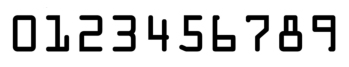

In [24]:
ref = cv2.imread("./data/ocr_a_reference.png")
plt.figure()
plt.axis("off")
plt.imshow(ref)

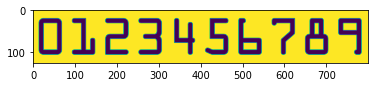

In [25]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
plt.imshow(ref)

# cv_show('ref', ref)

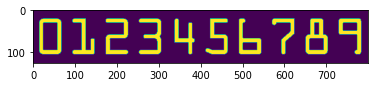

In [26]:
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

## Locate Contours on OCR-A Image

In [27]:
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

refCnts = refCnts[1] if imutils.is_cv3() else refCnts[0]

cv2.drawContours(ref, refCnts, -1, (155,155,155), 3) 

print(np.array(refCnts).shape)

(10,)


<img src='./data/Contours.png' width='60%'>

In [28]:
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [29]:
digits = {}

## loop through the contours, extract, and associate ROIs with their corresponding digits

In [30]:
# loop over the OCR-A reference contours, i holds the digit name/number and c holds the contour
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:(y + h), x:(x + w)]
    roi2 = cv2.resize(roi, (57, 88))
 
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

In [31]:
digits

{0: array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0, 155, ..., 155,   0,   0],
        ...,
        [  0, 155, 155, ..., 155, 155,   0],
        [  0,   0, 155, ..., 155,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 1: array([[  0, 155, 155, ...,   0,   0,   0],
        [155, 155, 155, ...,   0,   0,   0],
        [155, 155, 155, ...,   0,   0,   0],
        ...,
        [155, 155, 155, ..., 155, 155, 155],
        [155, 155, 155, ..., 155, 155, 155],
        [155, 155, 155, ..., 155, 155, 155]], dtype=uint8),
 2: array([[155, 155, 155, ...,   0,   0,   0],
        [155, 155, 155, ...,   0,   0,   0],
        [155, 155, 155, ..., 155,   0,   0],
        ...,
        [155, 155, 155, ..., 155, 155, 155],
        [155, 155, 155, ..., 155, 155, 155],
        [155, 155, 155, ..., 155, 155, 155]], dtype=uint8),
 3: array([[  0, 155, 155, ...,   0,   0,   0],
        [155, 155, 155, ..., 155,   0,   0],
    

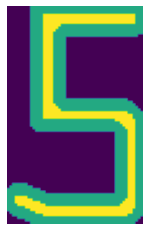

In [32]:
plt.figure()
plt.axis("off")
plt.imshow(digits[5])

In [33]:
# initialize Kernel: a rectangular (wider than it is tall) and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

## Load Input Card Number Image

In [3]:
# from google.colab import files
# import matplotlib.pyplot as mpplt
# import matplotlib.image as mpimg
# %matplotlib inline

# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
#   img = image.load_img(path, target_size=(150,150))
#   imgplot = mpplt.imshow(img)

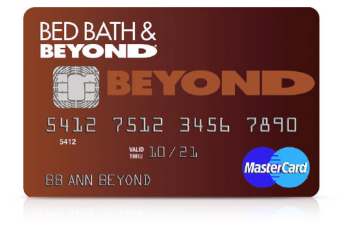

In [62]:
image = cv2.imread("./data/credit_card_03.png")
plt.figure()
plt.axis("off")
plt.imshow(image)

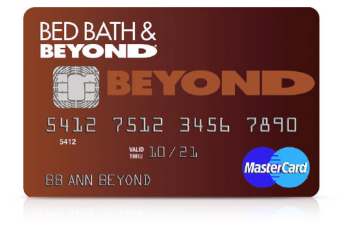

In [64]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.figure()
plt.axis("off")
plt.imshow(image)

## Resize it and convert it to grayscale

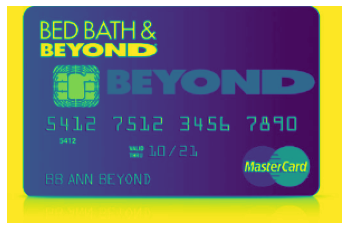

In [65]:
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray)

## apply a tophat (whitehat) morphological operator to find light regions against a dark background (i.e., the credit card numbers)

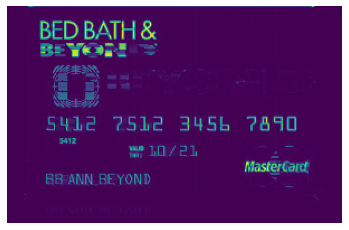

In [66]:
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.figure()
plt.axis("off")
plt.imshow(tophat)

## compute the Scharr gradient of the tophat image, then scale the rest back into the range [0, 255]

In [67]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

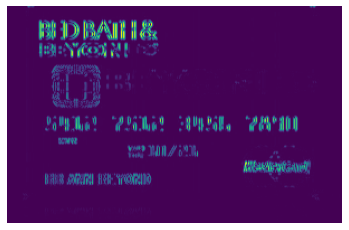

In [68]:
plt.figure()
plt.axis("off")
plt.imshow(gradX)

In [69]:
# apply a closing operation using the rectangular kernel to help cloes gaps in between credit card number digits, 
# then apply Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

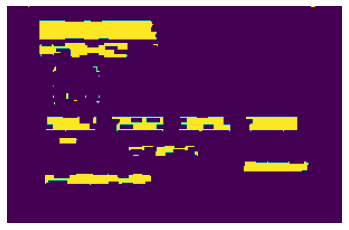

In [70]:
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [71]:
# apply a second closing operation to the binary image, again to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

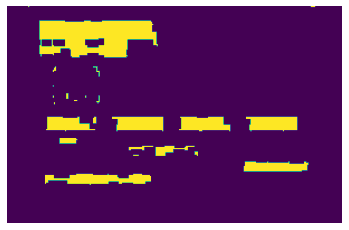

In [72]:
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [73]:
# find contours in the thresholded image, then initialize the list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv3() else cnts[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

cur_img = image.copy()

cv2.drawContours(cur_img, cnts, -1, (255,0,255), 2) 

print(np.array(cnts).shape)

(24,)


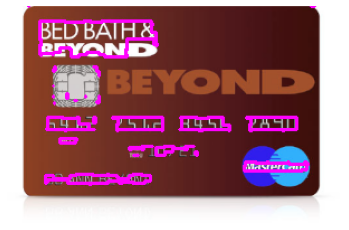

In [74]:
plt.figure()
plt.axis("off")
plt.imshow(cur_img)

In [75]:
locs = []

In [76]:
# loop over the contours
for (i, c) in enumerate(cnts):
    # compute the bounding box of the contour, then use the bounding box coordinates to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
 
    # since credit cards used a fixed size fonts with 4 groups of 4 digits, we can prune potential contours based on the aspect ratio
    if ar > 2.5 and ar < 4.5:
        # contours can further be pruned on minimum/maximum width and height
        if (w > 40 and w < 70) and (h > 10 and h < 20):
            # append the bounding box region of the digits group to our locations list
            locs.append((x, y, w, h))

In [77]:
# sort the digit locations from left-to-right, then initialize the list of classified digits
locs = sorted(locs, key=lambda x:x[0])

In [78]:
locs

[(35, 99, 44, 13), (94, 99, 46, 13), (154, 99, 46, 13), (214, 99, 46, 13)]

In [79]:
output = []

In [80]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []
 
    # extract the group ROI of 4 digits from the grayscale image, then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY-5 : gY+gH+5, gX-5 : gX+gW+5]
    # cv_show('group', group)
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # cv_show('group', group)
 
    # detect the contours of each individual digit in the group, then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    digitCnts = digitCnts[1] if imutils.is_cv3() else digitCnts[0]
    # digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

    # loop over the digit contours
    for c in digitCnts:
        # compute the bounding box of the individual digit, extract the digit, and resize it to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        # cv_show('roi', roi)
 
        # initialize a list of template matching scores	
        scores = []
 
        # loop over the reference digit name and digit ROI
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
 
        # the classification for the digit ROI will be the reference digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
        # draw the digit classifications around the group
        cv2.rectangle(image, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
 
    # update the output digits list
    output.extend(groupOutput)

In [81]:
print(output)

['5', '4', '1', '2', '7', '5', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']


In [82]:
# display the output credit card information to the screen
print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))

Credit Card Type: MasterCard


In [83]:
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 5412751234567890


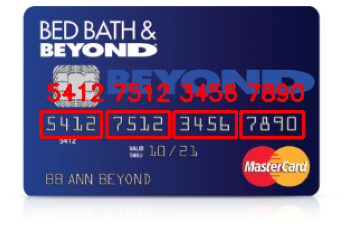

In [84]:
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))